# Molecular dynamics: stochastic continuous time models
## Computational Science with Python
## Yoav Ram

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import solve_ivp
import seaborn as sns
sns.set_context('talk')

- Gillespie algorithm: https://en.wikipedia.org/wiki/Gillespie_algorithm#Simple_example:_Reversible_binding_of_A_and_B_to_form_AB_dimers
- StochPy: http://stochpy.sourceforge.net/html/userguide_doc.html#module-1-demo
- SEIR model: https://github.com/naddleman/SEIR-stochastic
- SimPy: https://simpy.readthedocs.io/en/latest/ (generator-based)
- Barkai paper: http://www.pnas.org/content/99/9/5988.full
- Jupyter-based tutorial: http://be150.caltech.edu/2017/handouts/gillespie_simulation.html
- Python code and papers: https://github.com/karinsasaki/gillespie-algorithm-python

For simple protein production, we have the following reactions.

\begin{align}
\text{DNA} \rightarrow \text{mRNA} \rightarrow \text{protein}
\end{align}

The **master equation** which describes the change in the distribution $P$ of mRNA $m$ and protein $p$ over time $t$ is

$$
\frac{d P(m,p,t)}{dt} = 
\beta_m P(m-1,p,t) + 
(m+1)P(m+1,p,t) - 
\beta_m P(m,p,t) - 
mP(m,p,t) +
\beta_p mP(m,p-1,t) + 
\gamma_p (p+1)P(m,p+1,t) - 
\beta_p mP(m,p,t) - 
\gamma p P(m,p,t).
$$

where $\beta_m$ is the production rate of mRNA (relative to its "death" rate), $\beta_p$ is the production rate of protein (per mRNA molecule) relative to its "death" rate, and $t$ is scaled by the protein "death" rate (protein molecule "lives" for 1 time unit on average). 
We also assume $P(m,p,t) = 0$ if $m < 0$ or $p< 0$.

# Deterministic method
The deterministic equations, which describe the dynamics over a very large number of independent replicates, i.e. cells, is

$$
\frac{dm}{dt} = \beta_m - m \\
\frac{dp}{dt} = \beta_p m - \gamma p
$$

Note that these dynamics are linear in $m$ and $p$, unlike the predator-prey dynamics of the Lotka-Volterra equations.

The equilibrium can be calculated by equation both derivatives to zero:

$$
m = \beta_m \\
p = \frac{\beta_p}{\gamma} m = \frac{\beta_p}{\gamma \beta_m}
$$

The Jacobian is

$$
\pmatrix{
-1 & 0 \\
\beta_p & -\gamma
}
$$

The eigenvalues are the main diagonal values, $-1$ and $-\gamma$ (the matrix is already in Jordan form), which are both real and negative, so the equilibrium is locally stable. 
In fact we could also show that it is globally stable, i.e. the system reaches it regardless of the initial conditions, as long as $\beta_m, \beta_p > 0$.

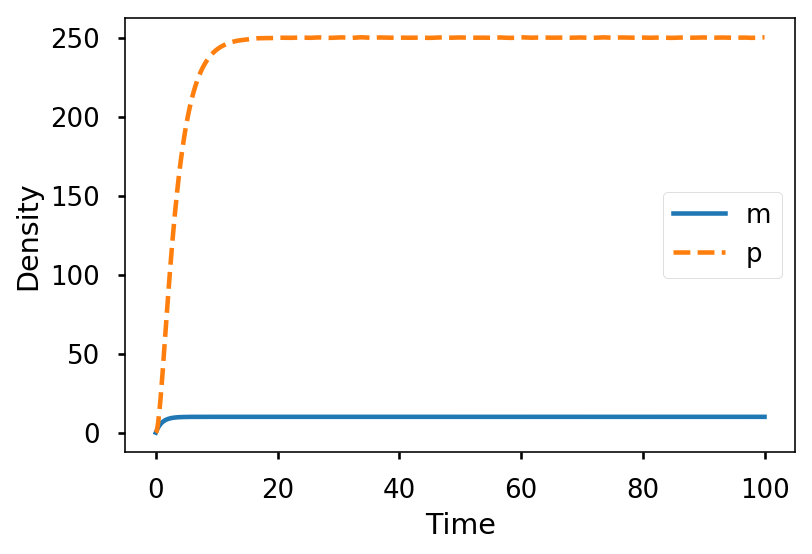

In [419]:
def dmpdt(t, mp, βm, βp, γ):
    m, p = mp
    return βm - m, βp * m - γ * p

def solve_det(βm, βp, γ, mp0=(0,0), tmax=100, tsteps=1000):
    dmpdt_ = lambda t, mp: dmpdt(t, mp, βm, βp, γ)
    t = np.linspace(0, tmax, tsteps)
    sol = solve_ivp(dmpdt_, (0, t.max()), mp0, t_eval=t)
    m, p = sol.y
    return t, m, p

def plot_mp(t, m, p, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(t, m, label='m')
    ax.plot(t, p, '--', label='p')
    ax.set_xlabel('Time')
    ax.set_ylabel('Density')
    ax.legend()
    return ax

t, m, p = solve_det(10, 10, 0.4)
plot_mp(t, m, p);

# Stochastic method: Gillespie algorithm

To implement a stochastic integration method, we first write the master equation as a list of reactions and their corresponding rates:

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\
m \rightarrow m-1, \;\;\;\; & m\\
p \rightarrow p+1, \;\;\;\; & \beta_p m \\
p \rightarrow p-1, \;\;\;\; & \gamma p.
\end{array}
\end{align}

The **Gillespie algorithm** is a method for sampling from the probability distribution $P(m,p,t)$. This was proven by Dobbs (XXX) and later implemented by Gillespie (XXX, XXX), see the papers for the technical details (or come see me).

The idea is that reactions are rare and discrete, and therefore represent separate events which can be modeled by a Poisson process with exponentially distributed waiting times.

Since the waiting times are exponentially distributed, their sum is also exponentially distributed with rate $\sum_i{a_i}$. 
Given that some reaction occured, the probability that it was reaction $r_i$ is 

$$
\frac{a_i}{\sum_j{a_j}}
$$

So the algorithm works like this, starting with an initial state $(t, m, p)$:
1. Calculate the reaction rates $a_i$.
1. Calculate their sum $\sum_i{a_i}$.
1. Draw the waiting time for the next event $\Delta t$ from $Exp(\sum_i{a_i})$.
1. Draw the type of the event from $Multinomial(1, a_i/\sum_i{a_i})$.
1. Find the state change $\Delta m, \Delta p$ due to reaction $r_i$
1. Update $(t, m, p)$ with the time update $\Delta t$ and the reaction change $\Delta m, \Delta p$.
1. Go to (1).

In [485]:
@numba.jit # 2-fold faster
def get_rates(m, p, βm, βp, γ):
    return np.array([
        βm,  # mRNA production
        m, # mRNA degradation
        βp * m,  # protein production
        γ * p  # protein degradation
    ])

NumPy's exponential random number generator accepts the mean value, or the 1/rate:

/Users/yoavram/miniconda3/envs/CompSciPy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.9984026667064723 1
1.9976955818159998 2
10.0087218598025 10


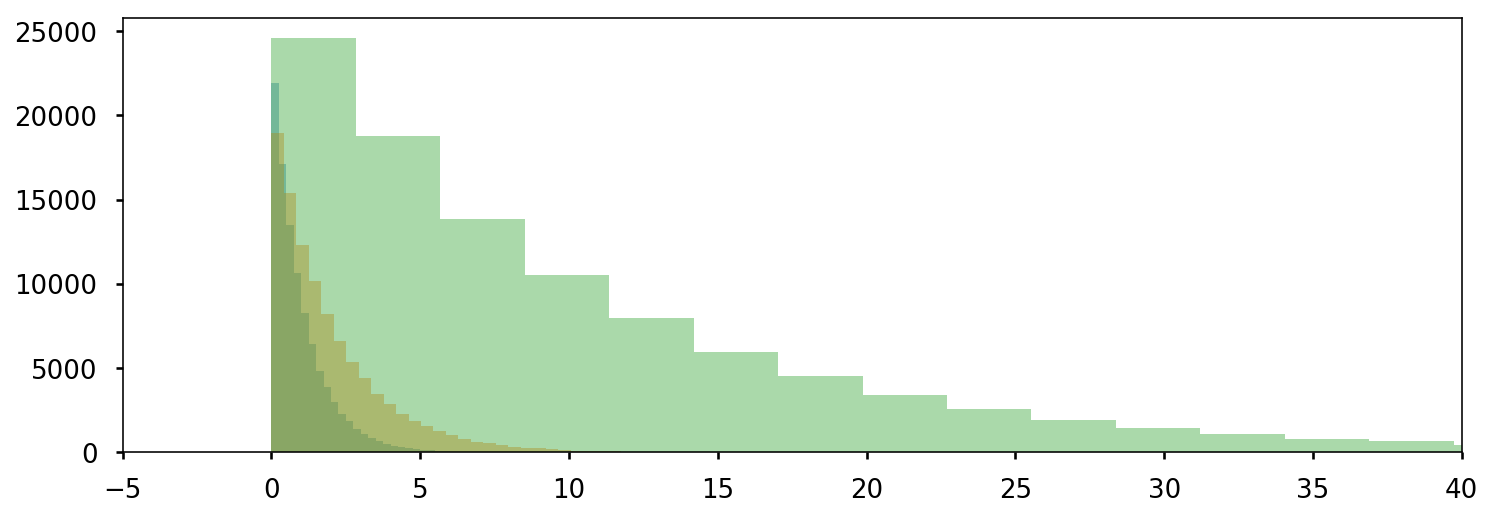

In [33]:
x1 = np.random.exponential(1, size=100000)
x2 = np.random.exponential(2, size=100000)
x10 = np.random.exponential(10, size=100000)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
kwargs = dict(kde=False)
sns.distplot(x1, **kwargs)
sns.distplot(x2, **kwargs)
sns.distplot(x10, **kwargs)
ax.set_xlim(-5, 40)

print(x1.mean(), 1)
print(x2.mean(), 2)
print(x10.mean(), 10)

In [486]:
@numba.jit # 2-fold faster
def draw_time(rates):
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)

In [537]:
# @numba.jit # jit causes errors with multinomial
def draw_reaction(rates):
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

In [91]:
updates = np.array([
    [1, 0],  # mRNA production
    [-1, 0], # mRNA degradation
    [0, 1],  # protein production
    [0, -1]  # protein degradation
])

In [611]:
def gillespie_step(m, p, βm, βp, γ):
    rates = get_rates(m, p, βm, βp, γ)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δm, Δp = updates[ri]
    return Δt, Δm, Δp

In [612]:
t, m, p = 0, 0, 0

In [613]:
Δt, Δm, Δp = gillespie_step(m, p, 10, 10, 0.4)
t, m, p = t+Δt, m+Δm, p+Δp
print(t, m, p)

0.10051371026772156 1 0


In [623]:
def gillespie_ssa(βm, βp, γ, t0=0, m0=0, p0=0, t_steps=1000, tmax=10):
    dt = (tmax - t0) / t_steps
    i = 0
    t, m, p = t0, m0, p0
    output = np.empty((3, t_steps))
    output[:,0] = t, m, p

    while t < tmax:
        Δt, Δm, Δp = gillespie_step(m, p, βm, βp, γ)
        t, m, p = t+Δt, m+Δm, p+Δp
        if t >= output[0, i] + dt:
            i += 1
            output[:, i] = t, m, p
    return output[:,:i+1]        

In [655]:
def gillespie_ssa(βm, βp, γ, t0=0, m0=0, p0=0, t_steps=1000, tmax=10):
    times = np.linspace(t0, tmax, t_steps)
    output = np.empty((updates.shape[1], t_steps))    
    
    t = t0
    m, p = m0, p0
    Δm, Δp = 0, 0
    for i, next_t in enumerate(times):
        while t < next_t:
            Δt, Δm, Δp = gillespie_step(m, p, βm, βp, γ)
            t, m, p = t+Δt, m+Δm, p+Δp
        output[:, i] = m - Δm, p - Δp
    return np.concatenate((times.reshape(1,-1), output), axis=0)

In [661]:
tmp = np.array([gillespie_ssa(10, 2, 0.4, tmax=50) for _ in range(100)])
T, M, P = solve_det(10, 2, 0.4, tmax=50)

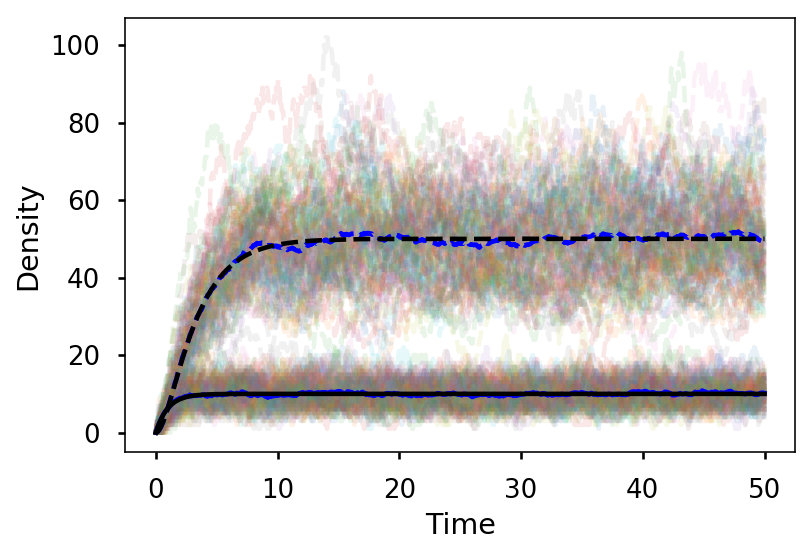

In [666]:
fig, ax = plt.subplots()

t = tmp[0,0,:]
m = tmp[:,1,:]
p = tmp[:,2,:]

plot_mp(t, m.T, p.T, ax=ax)
plot_mp(t, m.mean(axis=0), p.mean(axis=0), ax=ax)
plot_mp(T, M, P, ax=ax)

for line in ax.get_lines()[:-4]:
    line.set_alpha(0.1)
for line in ax.get_lines()[-4:-2]:
    line.set_color('b')
for line in ax.get_lines()[-2:]:
    line.set_color('k')
ax.legend().set_visible(False)

/Users/yoavram/miniconda3/envs/CompSciPy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


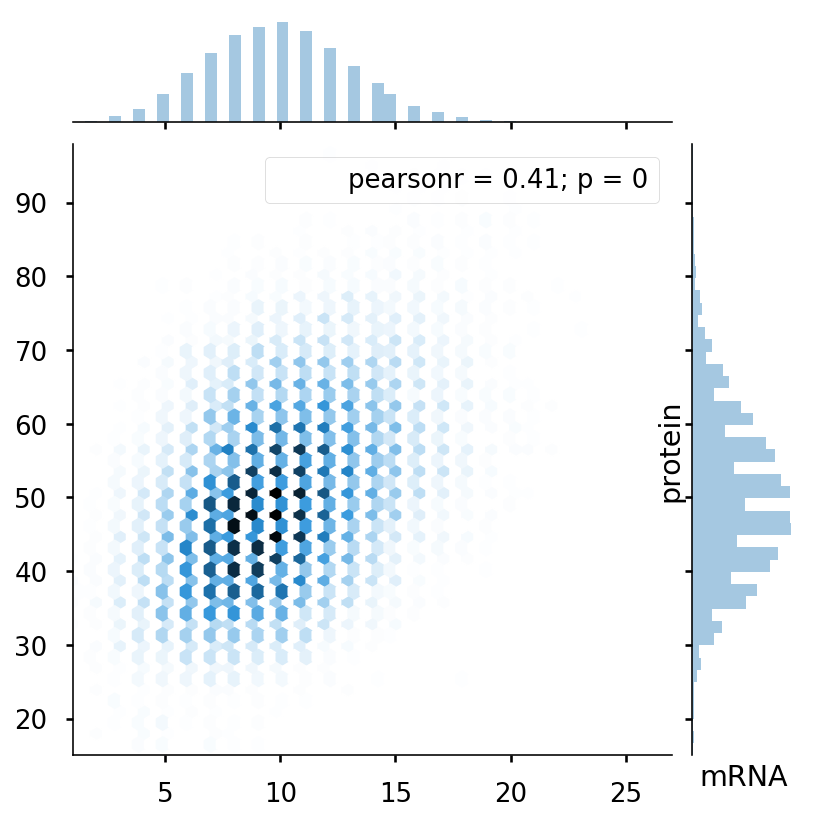

In [698]:
n = t.shape[0]//2

sns.jointplot(m[:,n:].ravel(), p[:,n:].ravel(), kind='hex')
plt.xlabel('mRNA')
plt.ylabel('protein');